# Perturbing graph structure

In [1]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from torch.nn.functional import one_hot
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from datetime import datetime
import os

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def to_np(tnsr):
    return tnsr.squeeze(0).detach().cpu().numpy().transpose((1,2,0))

In [4]:
device='cuda:3'

In [5]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [6]:
lgvae = LatentGraphVAE(n_channels=3, w=480//2, h=320//2, device=device)

In [7]:
# sd = torch.load(open('models/lgvae_20221208-0138.torch','rb'), map_location=device)
sd = torch.load('models/lgvae_20221208-0156.torch')#, map_location=device)

In [8]:
lgvae.load_state_dict(sd)

<All keys matched successfully>

In [9]:
lgvae = lgvae.to(device)

In [10]:
idl = iter(dataloader)


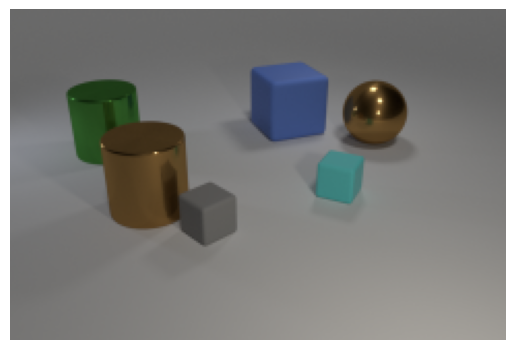

In [11]:
image,_ = next(idl)
image = image.to(device)
plt.axis('off')
# TODO why is this transposed?
plt.imshow(to_np(image).transpose(1,0,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


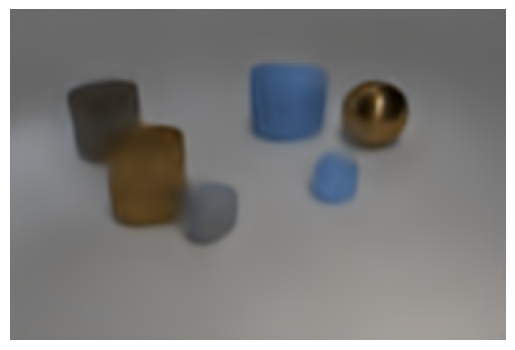

In [31]:
recon, nodes, attentions = lgvae(image.squeeze(0))#transpose(3,2).squeeze(0))

plt.axis('off')
plt.imshow(to_np(recon))

In [73]:
def remove_node(nodes, edge_index, node_idx):
    new_edges = edge_index[:,(edge_index != node_idx).sum(dim=0) == 2]
    new_nodes_mask = torch.arange(nodes.shape[0]) == node_idx
    new_nodes = torch.clone(nodes)
    new_nodes[new_nodes_mask]=0.0
    return nodes, new_edges

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


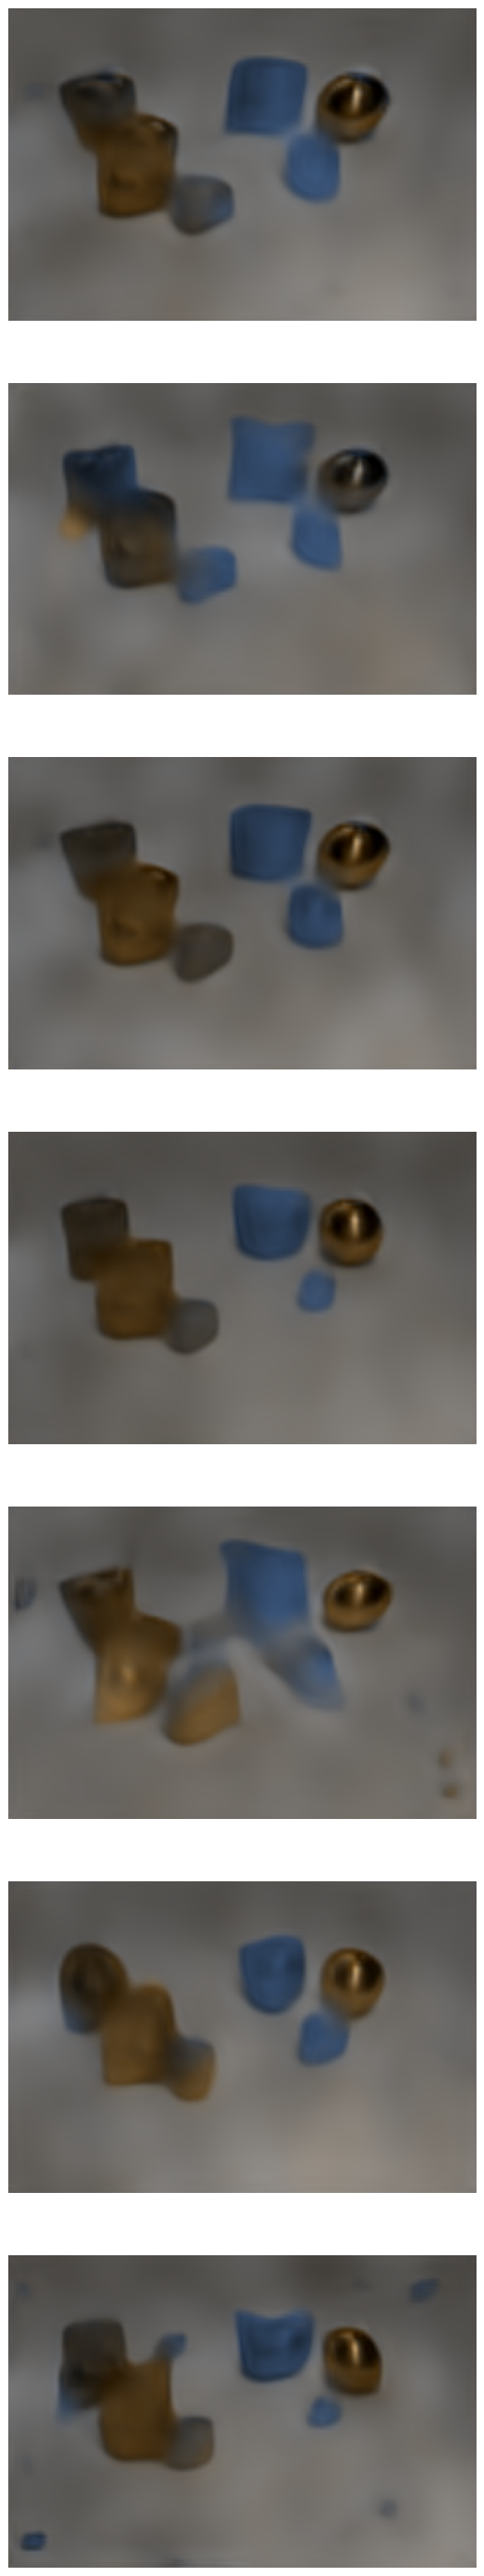

In [75]:
fig, axs = plt.subplots(7,1, figsize=(10,40))
for i in range(7):
    n,e = remove_node(nodes, edge_index, i)
    perturbed_nodes, _ = lgvae.graph_encode(n, e)
    perturbed = lgvae.decode(perturbed_nodes)
    axs[i].axis('off')
    axs[i].imshow(to_np(perturbed))